# Factor Regression

- Author: Wenzhi Ding
- Version: 2023-02-28

This notebook is to conduct factor regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Lasso

In [2]:
pd.__version__  # You may encounter problems with older versions of pandas. My code works with 1.5.2.

'1.5.2'

# Merge Data

In [17]:
ff = pd.read_csv('FF5_2000_2022.csv').set_index('YYYYMM') / 100  # Change scale
ff.shape
ff.head(3)

(276, 6)

,Mkt-RF,SMB,HML,RMW,CMA,RF
YYYYMM,,,,,,
200001,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041
200002,0.0245,0.1834,-0.0970,-0.1873,-0.0036,0.0043
200003,0.0520,-0.1535,0.0817,0.1182,-0.0165,0.0047


In [18]:
hxz = pd.read_csv('HXZ5_2000_2022.csv').set_index('YYYYMM') / 100  # Change scale
hxz.shape
hxz.head(3)

(276, 6)

,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG
YYYYMM,,,,,,
200001,0.004343,-0.047610,0.056171,0.029355,-0.049998,0.006306
200002,0.004295,0.024578,0.221445,-0.053931,-0.075531,-0.031129
200003,0.004377,0.052266,-0.144020,0.018350,0.076849,0.035080


In [19]:
ps = pd.read_csv('PS_2000_2022.csv').set_index('YYYYMM')
ps.shape
ps.head(3)

(264, 3)

,AggLiq,eq8,LIQ_V
YYYYMM,,,
200001,-0.067437,-0.045267,0.010806
200002,-0.041723,-0.013174,0.008217
200003,-0.006182,0.110161,-0.001077


In [20]:
# Combine factors
ft = pd.concat([ff, hxz, ps], axis=1).reset_index().dropna()
ft.shape
ft.head(3)

(264, 16)

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
0,200001,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.047610,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
1,200002,0.0245,0.1834,-0.0970,-0.1873,-0.0036,0.0043,0.004295,0.024578,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217
2,200003,0.0520,-0.1535,0.0817,0.1182,-0.0165,0.0047,0.004377,0.052266,-0.144020,0.018350,0.076849,0.035080,-0.006182,0.110161,-0.001077


In [21]:
ft.to_parquet('factor.pq')

In [22]:
st = pd.read_csv('CRSP_2000_2022.csv')
st.shape
st.head(3)

(82060, 4)

,PERMNO,YYYYMM,MthPrc,MthRet
0,10324,200001,52.0000,0.155556
1,10324,200002,57.4375,0.104567
2,10324,200003,50.1250,-0.127312


In [23]:
# Combine stock returns and factors
df = pd.merge(st, ft, on=['YYYYMM'], how='inner', validate='m:1')
df.shape
df.head(3)

(78116, 19)

,PERMNO,YYYYMM,MthPrc,MthRet,Mkt-RF,SMB,HML,RMW,CMA,RF,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
0,10324,200001,52.000,0.155556,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
1,10604,200001,77.000,-0.109827,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
2,10777,200001,60.875,-0.127240,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806


In [24]:
# How we merge datasets horizontally?

# 1. Merge by index: pd.concat
# df = pd.concat([ff, hxz, ps], axis=1)
# PS1: pd.concat = pd.merge(how='outer')

# 2. Merge by column: pd.merge
# df = pd.merge(ff, hxz, on='YYYYMM')
# df = pd.merge(df, ps, on='YYYYMM')

# df.head(3)

In [25]:
# How we merge datasets vertically?

# df = pd.concat([ff, hxz, ps], axis=0)
# df.shape
# df.head(3)

In [26]:
# Inner/outer/left/right merge
# df = pd.merge(ff, ps, on='YYYYMM', how='inner')
# df = pd.merge(ff, ps, on='YYYYMM', how='outer')
# df = pd.merge(ff, ps, on='YYYYMM', how='left')
# df = pd.merge(ff, ps, on='YYYYMM', how='right')

# df.shape
# df.tail(20)

In [27]:
# Recommended merge standard operating procedure (SOP)

# df = pd.merge(ff, ps, on=['YYYYMM'], how='outer', validate='1:1', indicator=True)
# df['_merge'].value_counts()
# df.sample(5)

# Parameter:
# how:        Use "outer" helps you track how misalign are the two datasets. 
#             This is crucial to detect potential problem of your data.
# validate:   Ensure the merge is consistent with your intention.
# indicator:  Add a column to indicate the source of each row.

In [28]:
df['MthRet'] -= df['RF']  # MthRet-RF
df['Const'] = 1  # Constant term
df.head(3)

,PERMNO,YYYYMM,MthPrc,MthRet,Mkt-RF,SMB,HML,RMW,CMA,RF,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
0,10324,200001,52.000,0.151456,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
1,10604,200001,77.000,-0.113927,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
2,10777,200001,60.875,-0.131340,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.04761,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1


In [29]:
# Drop redundant variables
# Priority: CRSP > FF > HXZ > PS
df.drop(columns=['MthPrc', 'R_F', 'R_MKT', 'RF'], inplace=True)
df.shape
df.head(3)

(78116, 16)

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
0,10324,200001,0.151456,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
1,10604,200001,-0.113927,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
2,10777,200001,-0.131340,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1


In [30]:
df.to_parquet('ret.pq')  # feather pickle

# Rolling Window Reg

In [37]:
df = pd.read_parquet('ret.pq').reset_index(drop=True)
df.shape
df.head(3)

(78116, 16)

,YYYYMM,PERMNO,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
0,200001,10324,0.151456,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
1,200002,10324,0.100267,0.0245,0.1834,-0.0970,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,1
2,200003,10324,-0.132012,0.0520,-0.1535,0.0817,0.1182,-0.0165,-0.144020,0.018350,0.076849,0.035080,-0.006182,0.110161,-0.001077,1


In [40]:
xvars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V', 'Const']
yvar = 'MthRet'

res = []
for i in set(df['PERMNO']):  # Loop through each stock
    df2 = df[df['PERMNO'] == i]
    try:  # Why use try-except? Because insufficient obs raises error.
        tmp = RollingOLS(df2[yvar], df2[xvars], window=60, expanding=True).fit(params_only=True)
        res.append(pd.concat([df2[['PERMNO', 'YYYYMM', 'MthRet']], tmp.params], axis=1))  # Save regression results for this stock
    except:
        # print(df2.shape)  # Insufficient obs to estimate
        pass

dfm = pd.concat(res).dropna()
dfm.shape
dfm.head(3)

(70414, 16)

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
61792,90112,200504,-0.022297,-0.951607,9.110221,0.777914,-3.393160,-10.000021,-6.653133,10.521474,-0.146192,1.085273,-2.055162,1.041455,0.450391,-0.049797
61793,90112,200505,0.018834,-0.576640,7.429164,0.638232,-2.802474,-8.074555,-5.365489,8.523739,-0.144527,1.017521,-1.680576,0.823677,0.407441,-0.040354
61794,90112,200506,0.018046,0.740874,2.604933,0.973689,-0.579940,-0.638850,-2.484445,0.296063,0.536086,-0.711759,-0.277482,0.108668,0.015726,-0.010682


In [ ]:
# Why some estimation has less than 60 months sample?

# If you want to include some stocks listed less than 5 years into your portfolio,
# it's fine to have less than 60 months sample as long as the system is identified.
# RollingOLS(expanding=True) relaxes the requirement of 60 months sample.

In [ ]:
# How we use the factor to predict returns?

# Remember that my estimation for 200504 use data from 200001 to 200504
# So you can only use these coefficients to predict return in and after 200505
# Otherwise, you will cause data leakage (look-ahead bias)

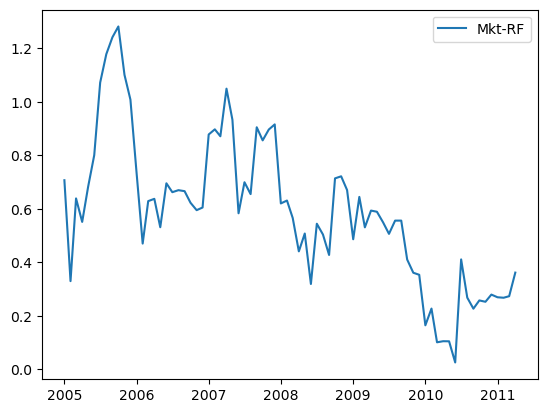

In [42]:
tmp = dfm.loc[(dfm['PERMNO'] == 10324) & (dfm['YYYYMM'] >= 200500)].copy()
tmp['date'] = pd.to_datetime(tmp['YYYYMM'], format='%Y%m')
for x in ['Mkt-RF']:
    _ = plt.plot(tmp['date'], tmp[x], label=x)  # _ is like a trash bin, receiving the return of a function that will never be used
_ = plt.legend()
plt.show()

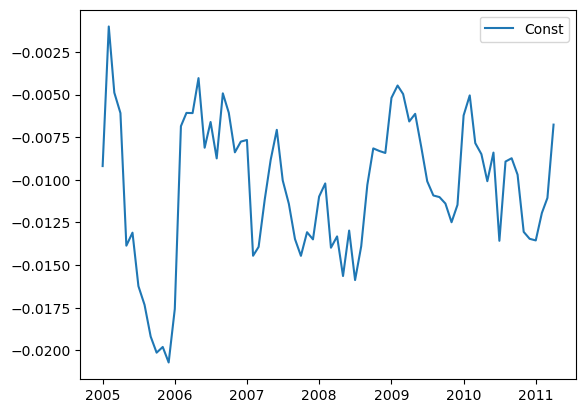

In [40]:
_ = plt.plot(tmp['date'], tmp[f'Const'], label='Const')
_ = plt.legend()
plt.show()

# Fama-MacBeth

In [43]:
dfm2 = dfm.rename(columns={'Const': 'alpha'}).dropna()
dfm2.shape
dfm2['Const'] = 1

(70414, 16)

In [42]:
res = []
for t in set(dfm2['YYYYMM']):
    v = dfm2.loc[dfm2['YYYYMM'] == t, xvars + [yvar]].values
    res.append(np.append(t, np.linalg.lstsq(v[:, :-1], v[:, -1], rcond=None)[0]))

# np.linalg.lstsq is for accelerating the regression if needed
# See: https://github.com/Wenzhi-Ding/coding_notes/blob/master/20_Tutorial/M220411_accelerate_numpy.ipynb

res = pd.DataFrame(res, columns=['YYYYMM'] + xvars).sort_values('YYYYMM').reset_index(drop=True)
res = res.loc[res['YYYYMM'] >= 200601]
res['YYYYMM'] = pd.to_datetime(res['YYYYMM'], format='%Y%m')
res.shape
res.head(3)

(192, 14)

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
60,2006-01-01,0.028544,0.054919,0.000914,-0.024634,-0.003994,0.062757,-0.003423,0.004658,-0.012264,0.016403,-0.036041,0.016777,0.007807
61,2006-02-01,-0.000567,-0.008920,0.001152,-0.017830,0.021365,-0.010428,0.021374,-0.016725,-0.020178,-0.039545,0.001805,-0.044737,0.006629
62,2006-03-01,0.009803,0.041167,0.005033,-0.005452,0.012321,0.036264,0.007223,0.004824,-0.021182,-0.033039,-0.003094,-0.002745,0.004908


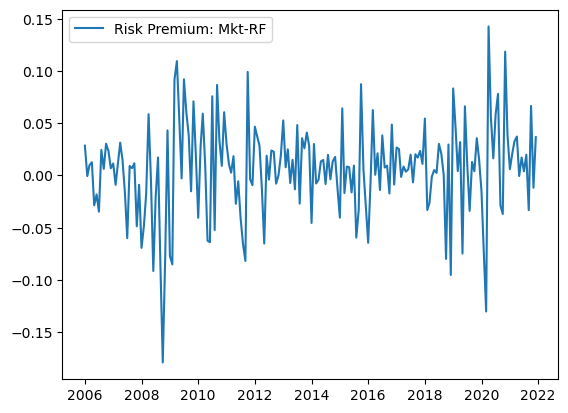

In [43]:
_ = plt.plot(res['YYYYMM'], res['Mkt-RF'], label='Risk Premium: Mkt-RF')
_ = plt.legend()
plt.show()

In [44]:
ff2 = ff.copy() / 100
ff2.reset_index(inplace=True) 
ff2['YYYYMM'] = pd.to_datetime(ff2['YYYYMM'], format='%Y%m')
ff2 = ff2.merge(res, on='YYYYMM', how='inner', suffixes=('', '_gamma'))
ff2.shape
ff2.head(3)

(192, 20)

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt-RF_gamma,SMB_gamma,HML_gamma,RMW_gamma,CMA_gamma,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
0,2006-01-01,0.0304,0.0575,0.0108,-0.0064,-0.0046,0.0035,0.028544,0.054919,0.000914,-0.024634,-0.003994,0.062757,-0.003423,0.004658,-0.012264,0.016403,-0.036041,0.016777,0.007807
1,2006-02-01,-0.0030,-0.0042,-0.0035,-0.0051,0.0191,0.0034,-0.000567,-0.008920,0.001152,-0.017830,0.021365,-0.010428,0.021374,-0.016725,-0.020178,-0.039545,0.001805,-0.044737,0.006629
2,2006-03-01,0.0146,0.0340,0.0059,0.0009,-0.0041,0.0037,0.009803,0.041167,0.005033,-0.005452,0.012321,0.036264,0.007223,0.004824,-0.021182,-0.033039,-0.003094,-0.002745,0.004908


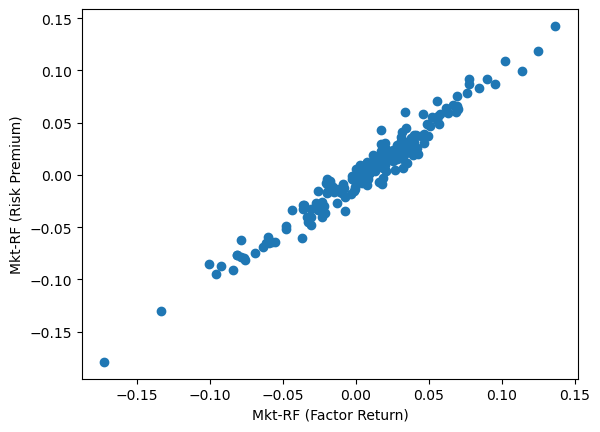

In [47]:
_ = plt.scatter(ff2['Mkt-RF'], ff2['Mkt-RF_gamma'])
_ = plt.xlabel('Mkt-RF (Factor Return)')
_ = plt.ylabel('Mkt-RF (Risk Premium)')
plt.show()

# LASSO

In [2]:
df = pd.read_parquet('ret.pq').reset_index(drop=True)
df.shape
df.head(3)

(78116, 16)

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const
0,10324,200001,0.151456,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
1,10604,200001,-0.113927,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1
2,10777,200001,-0.131340,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1


In [3]:
df['YYYYMM_bak'] = df['YYYYMM'].copy()
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y%m')
df.head(3)

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const,YYYYMM_bak
0,10324,2000-01-01,0.151456,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1,200001
1,10604,2000-01-01,-0.113927,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1,200001
2,10777,2000-01-01,-0.131340,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,1,200001


In [4]:
ft = pd.read_parquet('factor.pq')
ft.shape
ft['YYYYMM'] = pd.to_datetime(ft['YYYYMM'], format='%Y%m')
ft.head(3)

(264, 16)

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
0,2000-01-01,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,0.004343,-0.047610,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
1,2000-02-01,0.0245,0.1834,-0.0970,-0.1873,-0.0036,0.0043,0.004295,0.024578,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217
2,2000-03-01,0.0520,-0.1535,0.0817,0.1182,-0.0165,0.0047,0.004377,0.052266,-0.144020,0.018350,0.076849,0.035080,-0.006182,0.110161,-0.001077


In [5]:
xvars = [
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 
    'R_ME', 'R_IA', 'R_ROE', 'R_EG', 
    'AggLiq', 'eq8', 'LIQ_V'
    ]


for i in range(7):  # Here we focus on explaining return instead of predicting return. So we can include current month's factor.
    df = df.merge(ft[['YYYYMM'] + xvars], on=['YYYYMM'], suffixes=('', f'_l{i}'))
    df['YYYYMM'] = df['YYYYMM'] - pd.offsets.MonthEnd() - pd.offsets.MonthBegin()

    # df[[f'{x}_l{i}' for x in xvars]] = df.groupby('PERMNO')[xvars].shift(i)
    # This is wrong because you will loss the first i months of data for each stock.
    # You should use merge instead of shift.

df.dropna(inplace=True)  # Most ML models cannot handle missing values, so drop them.
df.reset_index(drop=True, inplace=True)  # Make sure index is continuous. Not necessary, but recommended.
df['YYYYMM'] = df['YYYYMM_bak'].copy()
df.head()

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const,YYYYMM_bak,Mkt-RF_l0,SMB_l0,HML_l0,RMW_l0,CMA_l0,R_ME_l0,R_IA_l0,R_ROE_l0,R_EG_l0,AggLiq_l0,eq8_l0,LIQ_V_l0,Mkt-RF_l1,SMB_l1,HML_l1,RMW_l1,CMA_l1,R_ME_l1,R_IA_l1,R_ROE_l1,R_EG_l1,AggLiq_l1,eq8_l1,LIQ_V_l1,Mkt-RF_l2,SMB_l2,HML_l2,RMW_l2,CMA_l2,R_ME_l2,R_IA_l2,R_ROE_l2,R_EG_l2,AggLiq_l2,eq8_l2,LIQ_V_l2,Mkt-RF_l3,SMB_l3,HML_l3,RMW_l3,CMA_l3,R_ME_l3,R_IA_l3,R_ROE_l3,R_EG_l3,AggLiq_l3,eq8_l3,LIQ_V_l3,Mkt-RF_l4,SMB_l4,HML_l4,RMW_l4,CMA_l4,R_ME_l4,R_IA_l4,R_ROE_l4,R_EG_l4,AggLiq_l4,eq8_l4,LIQ_V_l4,Mkt-RF_l5,SMB_l5,HML_l5,RMW_l5,CMA_l5,R_ME_l5,R_IA_l5,R_ROE_l5,R_EG_l5,AggLiq_l5,eq8_l5,LIQ_V_l5,Mkt-RF_l6,SMB_l6,HML_l6,RMW_l6,CMA_l6,R_ME_l6,R_IA_l6,R_ROE_l6,R_EG_l6,AggLiq_l6,eq8_l6,LIQ_V_l6
0,10324,200007,0.163444,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
1,10777,200007,0.020410,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
2,10933,200007,0.086992,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
3,10989,200007,0.000615,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0

In [6]:
df.to_parquet('ret_lag.pq')

In [40]:
# Why .groupby before .shift?

# df['MthRet_shift'] = df['MthRet'].shift(1)
# df['MthRet_groupby_shift'] = df.groupby('PERMNO')['MthRet'].shift(1)
# df.loc[128:131, ['YYYYMM', 'PERMNO', 'MthRet', 'MthRet_shift', 'MthRet_groupby_shift']]

# Stock 10777 at 200007 will use stock 10324's return at 201104 if simply use .shift(1)
# .groupby make sure the operation is within the same stock

In [41]:
res = []
for stock in set(df['PERMNO']):  # All stocks
    for yyyymm in [x * 100 + 1 for x in range(2005, 2021)]:  # 2005-01 ~ 2020-01
        tmp = df.loc[(df['PERMNO'] == stock) & (df['YYYYMM'] <= yyyymm)].tail(60)  # Last 60 months
        if tmp.shape[0] < 12: continue  # If the stock is listed less than 12 months, skip
        if yyyymm not in tmp['YYYYMM'].values: continue  # If the stock is delisted before this month, skip
        r = Lasso(alpha=0.001).fit(tmp.loc[:, 'Mkt-RF_l0':'LIQ_V_l6'].values, tmp['MthRet'].values)  # Lasso Regression
        res.append([stock, yyyymm] + np.where(r.coef_ != 0, 1, 0).tolist())  # 1 if the coefficient is non-zero and 0 otherwise

dfm = pd.DataFrame(res, columns=['PERMNO', 'YYYYMM'] + df.loc[:, 'Mkt-RF_l0':'LIQ_V_l6'].columns.tolist())
dfm.head(3)

,PERMNO,YYYYMM,Mkt-RF_l0,SMB_l0,HML_l0,RMW_l0,CMA_l0,R_ME_l0,R_IA_l0,R_ROE_l0,R_EG_l0,AggLiq_l0,eq8_l0,LIQ_V_l0,Mkt-RF_l1,SMB_l1,HML_l1,RMW_l1,CMA_l1,R_ME_l1,R_IA_l1,R_ROE_l1,R_EG_l1,AggLiq_l1,eq8_l1,LIQ_V_l1,Mkt-RF_l2,SMB_l2,HML_l2,RMW_l2,CMA_l2,R_ME_l2,R_IA_l2,R_ROE_l2,R_EG_l2,AggLiq_l2,eq8_l2,LIQ_V_l2,Mkt-RF_l3,SMB_l3,HML_l3,RMW_l3,CMA_l3,R_ME_l3,R_IA_l3,R_ROE_l3,R_EG_l3,AggLiq_l3,eq8_l3,LIQ_V_l3,Mkt-RF_l4,SMB_l4,HML_l4,RMW_l4,CMA_l4,R_ME_l4,R_IA_l4,R_ROE_l4,R_EG_l4,AggLiq_l4,eq8_l4,LIQ_V_l4,Mkt-RF_l5,SMB_l5,HML_l5,RMW_l5,CMA_l5,R_ME_l5,R_IA_l5,R_ROE_l5,R_EG_l5,AggLiq_l5,eq8_l5,LIQ_V_l5,Mkt-RF_l6,SMB_l6,HML_l6,RMW_l6,CMA_l6,R_ME_l6,R_IA_l6,R_ROE_l6,R_EG_l6,AggLiq_l6,eq8_l6,LIQ_V_l6
0,90112,200601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,90112,200701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,90112,200801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
pcts = dfm.drop(columns=['PERMNO']).groupby('YYYYMM').mean().T  # Non-zero rate by month

res = []

for yyyymm in [x * 100 + 1 for x in range(2005, 2021)]:
    res.append([yyyymm] + pcts.sort_values(yyyymm, ascending=False).head(5).index.tolist())

res = pd.DataFrame(res, columns=['YYYYMM', '1st', '2nd', '3rd', '4th', '5th'])
res

,YYYYMM,1st,2nd,3rd,4th,5th
0,200501,Mkt-RF_l0,AggLiq_l0,AggLiq_l3,eq8_l0,AggLiq_l1
1,200601,Mkt-RF_l0,AggLiq_l0,eq8_l0,AggLiq_l6,AggLiq_l3
2,200701,Mkt-RF_l0,AggLiq_l0,AggLiq_l6,AggLiq_l1,AggLiq_l5
3,200801,Mkt-RF_l0,AggLiq_l3,eq8_l5,AggLiq_l0,AggLiq_l5
4,200901,Mkt-RF_l0,AggLiq_l3,AggLiq_l0,eq8_l0,LIQ_V_l0
5,201001,Mkt-RF_l0,AggLiq_l0,eq8_l1,LIQ_V_l0,AggLiq_l4
6,201101,Mkt-RF_l0,AggLiq_l0,eq8_l0,AggLiq_l3,eq8_l1
7,201201,Mkt-RF_l0,AggLiq_l6,eq8_l1,AggLiq_l1,AggLiq_l3
8,201301,Mkt-RF_l0,eq8_l1,AggLiq_l5,AggLiq_l0,AggLiq_l1
9,201401,Mkt-RF_l0,AggLiq_l4,AggLiq_l5,eq8_l3,AggLiq_l6


<AxesSubplot: xlabel='YYYYMM'>

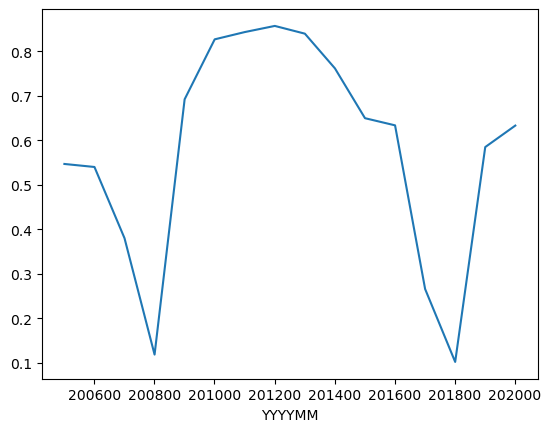

In [43]:
dfm.drop(columns=['PERMNO']).groupby('YYYYMM').mean()['Mkt-RF_l0'].plot()

# Mean-Variance

In [7]:
df = pd.read_parquet('ret_lag.pq').reset_index(drop=True)
df.shape
df.head(3)

(76565, 101)

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const,YYYYMM_bak,Mkt-RF_l0,SMB_l0,HML_l0,RMW_l0,CMA_l0,R_ME_l0,R_IA_l0,R_ROE_l0,R_EG_l0,AggLiq_l0,eq8_l0,LIQ_V_l0,Mkt-RF_l1,SMB_l1,HML_l1,RMW_l1,CMA_l1,R_ME_l1,R_IA_l1,R_ROE_l1,R_EG_l1,AggLiq_l1,eq8_l1,LIQ_V_l1,Mkt-RF_l2,SMB_l2,HML_l2,RMW_l2,CMA_l2,R_ME_l2,R_IA_l2,R_ROE_l2,R_EG_l2,AggLiq_l2,eq8_l2,LIQ_V_l2,Mkt-RF_l3,SMB_l3,HML_l3,RMW_l3,CMA_l3,R_ME_l3,R_IA_l3,R_ROE_l3,R_EG_l3,AggLiq_l3,eq8_l3,LIQ_V_l3,Mkt-RF_l4,SMB_l4,HML_l4,RMW_l4,CMA_l4,R_ME_l4,R_IA_l4,R_ROE_l4,R_EG_l4,AggLiq_l4,eq8_l4,LIQ_V_l4,Mkt-RF_l5,SMB_l5,HML_l5,RMW_l5,CMA_l5,R_ME_l5,R_IA_l5,R_ROE_l5,R_EG_l5,AggLiq_l5,eq8_l5,LIQ_V_l5,Mkt-RF_l6,SMB_l6,HML_l6,RMW_l6,CMA_l6,R_ME_l6,R_IA_l6,R_ROE_l6,R_EG_l6,AggLiq_l6,eq8_l6,LIQ_V_l6
0,10324,200007,0.163444,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
1,10777,200007,0.020410,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806
2,10933,200007,0.086992,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806


In [8]:
xvars = ['Mkt-RF_l0', 'AggLiq_l0', 'AggLiq_l1', 'AggLiq_l2', 'eq8_l0', 'eq8_l1', 'eq8_l2', 'LIQ_V_l0', 'LIQ_V_l1', 'LIQ_V_l2']
# xvars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']
yvar = 'MthRet'

In [9]:
rets = []

for y in range(2005, 2021):
    # This part could be confusing. 
    # You can run it step by step to see what's going on.

    # Prepare data
    tmp = df.loc[df['YYYYMM'].between((y - 5) * 100 + 1, (y - 1) * 100 + 12)].copy().dropna().reset_index(drop=True)
    tmp['nobs'] = tmp.groupby(['PERMNO'])['YYYYMM'].transform('count')
    tmp = tmp.loc[tmp['nobs'] >= 12].copy()  # Only stocks with at least 12 months of data

    # Calculate coefficients
    res = tmp.groupby('PERMNO').apply(lambda x: np.linalg.lstsq(x[xvars + ['Const']].values, x[yvar].values, rcond=None)[0]).to_frame()
    res[[f'coef_{x}' for x in xvars] + ['coef_Const']] = res[0].apply(pd.Series)
    tmp = tmp.merge(res, on='PERMNO')
    
    # Calculate residuals
    tmp['resid'] = tmp[yvar] - tmp['coef_Const']
    for x in xvars:
        tmp['resid'] -= tmp[f'coef_{x}'] * tmp[x]

    # Covariance matrix
    sigma = tmp.groupby('PERMNO')['resid'].var()
    B = res.drop(columns=[0, 'coef_Const'])
    cov = tmp.drop_duplicates(subset=['YYYYMM'])[xvars].cov()
    SIGMA = B.values @ cov.values @ B.values.T  + np.diag(sigma.values)  # @ is matrix multiplication
    mu = tmp.groupby('PERMNO')['MthRet'].mean()

    # Optimal weights
    res['w'] = np.linalg.inv(SIGMA) @ mu.values
    res['w'] /= res['w'].sum()  # Standardize weights

    # Portfolio monthly return
    res2 = res[['w']]
    tmp2 = df.loc[(df['PERMNO'].isin(res2.index)) & df['YYYYMM'].between(y * 100 + 1, y * 100 + 12), ['YYYYMM', 'PERMNO', 'MthRet']].copy()
    tmp2 = tmp2.merge(res2, on='PERMNO')
    tmp2['wgt_ret'] = tmp2['w'] * tmp2['MthRet']
    port_ret = tmp2.groupby('YYYYMM')['wgt_ret'].sum()

    rets.append(port_ret)

rets = pd.concat(rets)
rets.shape
rets.head()

(192,)

YYYYMM
200501   -0.036528
200502    0.008991
200503   -0.020497
200504   -0.013949
200505    0.045160
Name: wgt_ret, dtype: float64

<AxesSubplot: xlabel='YYYYMM'>

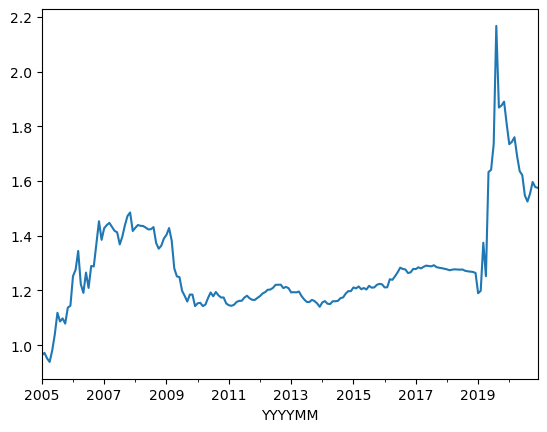

In [10]:
cum_ret = (rets + 1).cumprod()
cum_ret.index = pd.to_datetime(cum_ret.index, format='%Y%m')
cum_ret.plot()

In [11]:
def max_drawdown(x):
    return (x / x.expanding().max()).min() - 1

def sharpe(x):
    return x.mean() / x.std()

In [12]:
max_drawdown(cum_ret)
sharpe(rets) * np.sqrt(12)  # Remember to annualize your Sharpe ratio
# annualized sharpe ratio > 1.7: Could be a good strategy

-0.29615966427477924

0.2695643243286912

In [13]:
# Below shows you how the variables look like
B.shape
B.head(3)

(343, 10)

,coef_Mkt-RF_l0,coef_AggLiq_l0,coef_AggLiq_l1,coef_AggLiq_l2,coef_eq8_l0,coef_eq8_l1,coef_eq8_l2,coef_LIQ_V_l0,coef_LIQ_V_l1,coef_LIQ_V_l2
PERMNO,,,,,,,,,,
10777,1.022177,-0.251889,0.519506,-0.139566,0.236128,-0.390786,0.245048,-0.001797,-0.189716,-0.081356
10933,0.604348,0.141120,0.251369,-0.170286,-0.151663,-0.078587,0.301447,0.050311,-0.091066,0.075835
11587,0.050860,0.054779,0.352799,-0.240621,0.095973,-0.014930,-0.030239,0.122391,-0.862461,0.714947


In [14]:
cov.shape
cov.head(3)

(10, 10)

,Mkt-RF_l0,AggLiq_l0,AggLiq_l1,AggLiq_l2,eq8_l0,eq8_l1,eq8_l2,LIQ_V_l0,LIQ_V_l1,LIQ_V_l2
Mkt-RF_l0,0.001291,0.000155,-0.000007,0.000235,0.000221,-0.000267,0.000383,0.000045,-0.000173,0.000049
AggLiq_l0,0.000155,0.002854,-0.000119,-0.000145,0.002012,-0.000463,-0.000079,0.000042,0.000112,-0.000027
AggLiq_l1,-0.000007,-0.000119,0.002864,-0.000152,-0.000460,0.002034,-0.000481,0.000072,0.000055,0.000121


In [15]:
sigma.shape
sigma.head(3)

(343,)

PERMNO
10777    0.002399
10933    0.000997
11587    0.003256
Name: resid, dtype: float64

In [16]:
mu.shape
mu.head(3)

(343,)

PERMNO
10777    0.014145
10933    0.008688
11587    0.015531
Name: MthRet, dtype: float64

# Other Strategies

<AxesSubplot: xlabel='YYYYMM'>

-0.4254399713788949

0.945518549038362

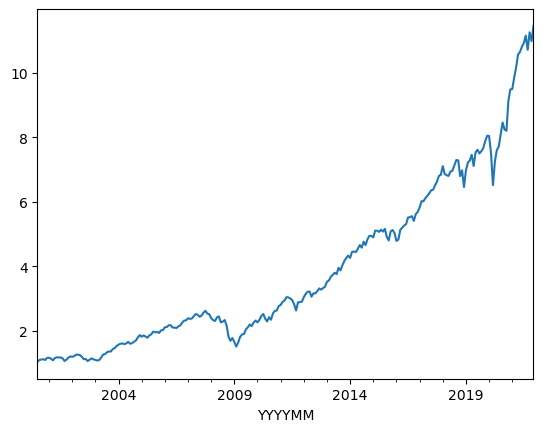

In [17]:
# Heuristic portfolios: Equal-weighted
ew_rets = df.groupby(['YYYYMM'])['MthRet'].mean()
ew_cum_ret = (ew_rets + 1).cumprod()
ew_cum_ret.index = pd.to_datetime(ew_cum_ret.index, format='%Y%m')
ew_cum_ret.plot()
max_drawdown(ew_cum_ret)
sharpe(ew_rets) * np.sqrt(12)  # Remember to annualize your Sharpe ratio

<AxesSubplot: xlabel='YYYYMM'>

-0.09778558767053824

0.9551821730566007

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,Const,YYYYMM_bak,Mkt-RF_l0,SMB_l0,HML_l0,RMW_l0,CMA_l0,R_ME_l0,R_IA_l0,R_ROE_l0,R_EG_l0,AggLiq_l0,eq8_l0,LIQ_V_l0,Mkt-RF_l1,SMB_l1,HML_l1,RMW_l1,CMA_l1,R_ME_l1,R_IA_l1,R_ROE_l1,R_EG_l1,AggLiq_l1,eq8_l1,LIQ_V_l1,Mkt-RF_l2,SMB_l2,HML_l2,RMW_l2,CMA_l2,R_ME_l2,R_IA_l2,R_ROE_l2,R_EG_l2,AggLiq_l2,eq8_l2,LIQ_V_l2,Mkt-RF_l3,SMB_l3,HML_l3,RMW_l3,CMA_l3,R_ME_l3,R_IA_l3,R_ROE_l3,R_EG_l3,AggLiq_l3,eq8_l3,LIQ_V_l3,Mkt-RF_l4,SMB_l4,HML_l4,RMW_l4,CMA_l4,R_ME_l4,R_IA_l4,R_ROE_l4,R_EG_l4,AggLiq_l4,eq8_l4,LIQ_V_l4,Mkt-RF_l5,SMB_l5,HML_l5,RMW_l5,CMA_l5,R_ME_l5,R_IA_l5,R_ROE_l5,R_EG_l5,AggLiq_l5,eq8_l5,LIQ_V_l5,Mkt-RF_l6,SMB_l6,HML_l6,RMW_l6,CMA_l6,R_ME_l6,R_IA_l6,R_ROE_l6,R_EG_l6,AggLiq_l6,eq8_l6,LIQ_V_l6,MthRet_lag,MthRet_lag_rank,Pos,wgt_ret
0,10324,200007,0.163444,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,NaN,NaN,0,0.0
1,10777,200007,0.020410,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,NaN,NaN,0,0.0
2,10933,200007,0.086992,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.076849,0.03508,-0.006182,0.110161,-0.001077,0.0245,0.1834,-0.097,-0.1873,-0.0036,0.221445,-0.053931,-0.075531,-0.031129,-0.041723,-0.013174,0.008217,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.056171,0.029355,-0.049998,0.006306,-0.067437,-0.045267,0.010806,NaN,NaN,0,0.0
3,10989,200007,0.000615,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,1,200007,-0.0251,-0.0103,0.083,0.0582,0.0295,0.00995,0.022468,0.034292,0.032749,0.055626,-0.061773,0.111081,0.0464,0.0993,-0.0843,-0.0832,-0.0293,0.102649,-0.033905,-0.047546,-0.018045,-0.181066,-0.156034,-0.034061,-0.0442,-0.0384,0.0481,0.0417,0.013,-0.04595,0.005085,0.000196,0.037028,0.065954,0.082662,-0.025511,-0.064,-0.0501,0.0726,0.0766,0.0565,-0.048609,0.037873,0.087094,0.05105,-0.225304,-0.217507,-0.043612,0.052,-0.1535,0.0817,0.1182,-0.0165,-0.14402,0.01835,0.0

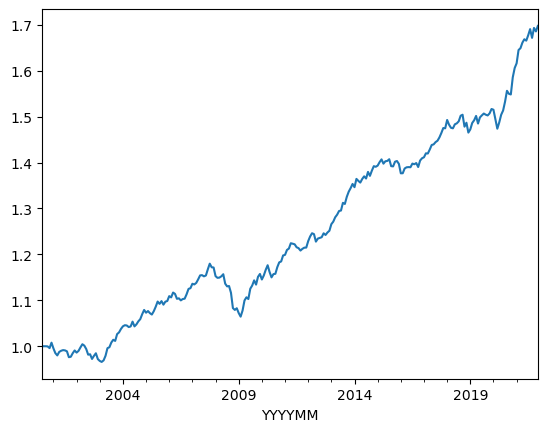

In [18]:
# Heuristic portfolios: Momentum
df['MthRet_lag'] = 0
for i in range(1, 4):
    df['MthRet_lag'] += df.groupby(['PERMNO'])['MthRet'].shift(i)
df['MthRet_lag_rank'] = df.groupby(['YYYYMM'])['MthRet_lag'].rank(method='first', pct=True)
df['Pos'] = df['MthRet_lag_rank'].apply(lambda x: 1 if x >= 0.8 else 0)
df['wgt_ret'] = df['Pos'] * df['MthRet']

mm_rets = df.groupby(['YYYYMM'])['wgt_ret'].mean()
mm_cum_ret = (mm_rets + 1).cumprod()
mm_cum_ret.index = pd.to_datetime(mm_cum_ret.index, format='%Y%m')
mm_cum_ret.plot()
max_drawdown(mm_cum_ret)
sharpe(mm_rets) * np.sqrt(12)  # Remember to annualize your Sharpe ratio
df.head(5) 